In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
#num_vel_points = 5200  # Velocity data points
#num_collocation_points = 50000  # Collocation points

In [3]:
# Domain parameters (3D)
x_min, x_max = 0.0, 4.0  # km
y_min, y_max = 0.0, 4.0  # km
z_min, z_max = 0.0, 4.0  # km
dx, dy, dz = 0.04, 0.04, 0.04  # km
nx, ny, nz = 101, 101, 101  # grid points

# Velocity model parameters
v0 = 2.0  # km/s at surface
vertgrad = 0.25  # s^{-1} (vertical gradient)
horigrad = 0.0   # horizontal gradient

# Generate 20 random sources
num_sources = 20
sources = torch.rand(num_sources, 3) * torch.tensor([[x_max - x_min, y_max - y_min, z_max - z_min]]) + torch.tensor([[x_min, y_min, z_min]])
sources = sources.to(device)

# Generate 3D grid coordinates
x = torch.linspace(x_min, x_max, nx, device=device)
y = torch.linspace(y_min, y_max, ny, device=device)
z = torch.linspace(z_min, z_max, nz, device=device)
X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
coords = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=1)

# Velocity model (vertically varying)
velmodel = v0 + vertgrad * Z

In [4]:
def print_source_coordinates(sources):
    """
    Print coordinates of randomly generated sources
    
    Args:
        sources: Tensor of source coordinates with shape (num_sources, 3)
    """
    print("\nRandomly generated source coordinates:")
    print(f"{'Index':<8} {'X (km)':<10} {'Y (km)':<10} {'Z (km)':<10}")
    print("-" * 40)
    for i, src in enumerate(sources):
        print(f"{i:<8} {src[0].item():<10.4f} {src[1].item():<10.4f} {src[2].item():<10.4f}")

print_source_coordinates(sources)


Randomly generated source coordinates:
Index    X (km)     Y (km)     Z (km)    
----------------------------------------
0        3.5291     3.6600     1.5315    
1        3.8372     1.5618     2.4036    
2        1.0263     3.1746     3.7631    
3        0.5327     3.7384     2.3743    
4        3.4776     2.2709     2.9644    
5        1.7176     3.5418     2.2956    
6        1.0663     2.5098     1.0785    
7        1.7655     1.1877     3.3267    
8        0.4213     1.0780     1.4353    
9        0.7975     2.1888     0.0246    
10       3.8062     0.3011     3.5441    
11       2.3328     1.3506     3.2359    
12       2.3117     3.6159     2.2186    
13       1.3693     2.5374     1.4576    
14       2.8417     3.7856     3.1561    
15       1.1257     3.1545     2.3579    
16       3.0157     0.7810     0.0202    
17       1.2273     0.4660     3.6411    
18       2.5761     2.8284     2.6325    
19       1.9652     3.5652     0.5790    


In [5]:
# Analytical solution for reference traveltime field T0
def calculate_T0(x, y, z, xs, ys, zs, v_ref):
    r = torch.sqrt((x - xs)**2 + (y - ys)**2 + (z - zs)**2)
    return r / v_ref

# Prepare training data
num_vel_points = 5200  # Velocity data points
num_collocation_points = 50000  # Collocation points
epsilon = 0.05  # Minimum distance from source

# Boundary points (sources) - format: [x, y, z, xs, ys, zs]
boundary_coords = torch.cat([sources, sources], dim=1)  # Each source paired with itself

# Velocity points: random locations + random source assignments
vel_pts = torch.rand(num_vel_points, 3, device=device) * torch.tensor([[x_max-x_min, y_max-y_min, z_max-z_min]], device=device) + torch.tensor([[x_min, y_min, z_min]], device=device)
vel_src_idx = torch.randint(0, num_sources, (num_vel_points,), device=device)
vel_srcs = sources[vel_src_idx]
vel_coords = torch.cat([vel_pts, vel_srcs], dim=1)
vel_true = v0 + vertgrad * vel_pts[:, 2].unsqueeze(1)

# Collocation points: avoid sources
colloc_pts = torch.rand(num_collocation_points, 3, device=device) * torch.tensor([[x_max-x_min, y_max-y_min, z_max-z_min]], device=device) + torch.tensor([[x_min, y_min, z_min]], device=device)
colloc_src_idx = torch.randint(0, num_sources, (num_collocation_points,), device=device)
colloc_srcs = sources[colloc_src_idx]

# Filter points too close to their assigned source
distances = torch.norm(colloc_pts - colloc_srcs, dim=1)
valid_indices = distances > epsilon
colloc_pts = colloc_pts[valid_indices][:num_collocation_points]
colloc_srcs = colloc_srcs[valid_indices][:num_collocation_points]
colloc_coords = torch.cat([colloc_pts, colloc_srcs], dim=1)

# Precompute T0 and gradients for collocation points
colloc_coords.requires_grad_(True)
xs, ys, zs = colloc_coords[:, 3], colloc_coords[:, 4], colloc_coords[:, 5]
v_ref = v0 + vertgrad * zs
T0_col = calculate_T0(colloc_coords[:, 0], colloc_coords[:, 1], colloc_coords[:, 2], xs, ys, zs, v_ref)

# Compute gradients
grad_T0 = torch.autograd.grad(
    T0_col, colloc_coords, 
    grad_outputs=torch.ones_like(T0_col),
    create_graph=False,
    retain_graph=False
)[0]
dT0dx, dT0dy, dT0dz = grad_T0[:, 0], grad_T0[:, 1], grad_T0[:, 2]

# Detach for training AND reshape to [N, 1]
T0_col = T0_col.detach().view(-1, 1)          # [N] -> [N, 1]
dT0dx = dT0dx.detach().view(-1, 1)            # [N] -> [N, 1]
dT0dy = dT0dy.detach().view(-1, 1)            # [N] -> [N, 1]
dT0dz = dT0dz.detach().view(-1, 1)            # [N] -> [N, 1]

In [6]:
import time
start_time = time.time()

# Adaptive ELM network for 3D
class A_ELM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(A_ELM, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, 1)
        
        # SIREN-inspired initialization
        omega_0 = 420.0
        bound = math.sqrt(6.0 / input_size) / omega_0
        nn.init.uniform_(self.hidden.weight, -bound, bound)
        nn.init.uniform_(self.hidden.bias, -bound, bound)
        self.hidden.requires_grad_(False)  # Freeze hidden weights
        
        # Trainable slope parameters
        self.a = nn.Parameter(30.0 * torch.ones(hidden_size))
        
    def forward(self, x):
        linear = self.hidden(x)
        activated = torch.sin(self.a * linear)
        raw = self.output_layer(activated)
        return torch.exp(raw)  # Ensure positive output

# Initialize ELM networks for u and v
hidden_size = 2000
elm_u = A_ELM(6, hidden_size).to(device)  # Input: [x, y, z, xs, ys, zs]
elm_v = A_ELM(6, hidden_size).to(device)

# Loss coefficients
lambda_bc = 1e4    # Boundary loss weight
lambda_vel = 1e2   # Velocity loss weight
lambda_pde = 1e1   # Physics loss weight

# Optimizer
optimizer = optim.Adam(
    [
        {'params': elm_u.output_layer.parameters()},
        {'params': elm_u.a},
        {'params': elm_v.output_layer.parameters()},
        {'params': elm_v.a}
    ],
    lr=0.0005
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=100
)

# Training loop
num_epochs = 1000
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Boundary loss (u=1 at sources)
    u_pred_src = elm_u(boundary_coords)
    loss_bc = torch.mean((u_pred_src - 1.0)**2)
    
    # Velocity loss
    v_pred_vel = elm_v(vel_coords)
    loss_vel = torch.mean((v_pred_vel - vel_true)**2)
    
    # Physics loss (Eikonal equation)
    colloc_input = colloc_coords.clone().requires_grad_(True)
    u_pred_col = elm_u(colloc_input)
    v_pred_col = elm_v(colloc_input)
    
    # Compute gradients of u w.r.t spatial coordinates (x,y,z)
    grad_u = torch.autograd.grad(
        u_pred_col, colloc_input, 
        grad_outputs=torch.ones_like(u_pred_col),
        create_graph=True
    )[0][:, :3]  # Only spatial gradients
    
    # Split and keep as column vectors [N, 1]
    dudx = grad_u[:, 0:1]   # [N,1] 
    dudy = grad_u[:, 1:2]   # [N,1]
    dudz = grad_u[:, 2:3]   # [N,1]   
    
    # Compute T gradients (T = T0 * u)
    dTdx = u_pred_col * dT0dx + T0_col * dudx
    dTdy = u_pred_col * dT0dy + T0_col * dudy
    dTdz = u_pred_col * dT0dz + T0_col * dudz
    
    # Eikonal residual
    pde_residual = dTdx**2 + dTdy**2 + dTdz**2 - 1/(v_pred_col**2)
    loss_pde = torch.mean(pde_residual**2)
    
    # Total loss
    total_loss = lambda_bc * loss_bc + lambda_vel * loss_vel + lambda_pde * loss_pde
    total_loss.backward()
    optimizer.step()
    scheduler.step(total_loss)
    loss_history.append(total_loss.item())
    
    if epoch % 100 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.6f}, LR = {current_lr:.2e}")

elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

Epoch 0/1000, Loss: 301.549042, LR = 5.00e-04
Epoch 100/1000, Loss: 4.038608, LR = 5.00e-04
Epoch 200/1000, Loss: 0.530742, LR = 5.00e-04
Epoch 300/1000, Loss: 0.087263, LR = 5.00e-04
Epoch 400/1000, Loss: 0.061207, LR = 5.00e-04
Epoch 500/1000, Loss: 0.053634, LR = 5.00e-04
Epoch 600/1000, Loss: 0.047158, LR = 5.00e-04
Epoch 700/1000, Loss: 0.041563, LR = 5.00e-04
Epoch 800/1000, Loss: 0.036834, LR = 5.00e-04
Epoch 900/1000, Loss: 0.032922, LR = 5.00e-04
Training time: 80.41 minutes


In [7]:
# Predict for a specific source in batches
src_idx = 0
src_coords = sources[src_idx].repeat(coords.shape[0], 1)
eval_coords = torch.cat([coords, src_coords], dim=1)

batch_size = 50000  # Adjust based on available memory
u_pred = torch.zeros(coords.shape[0], 1, device='cpu')
v_pred = torch.zeros(coords.shape[0], 1, device='cpu')

elm_u.eval()
elm_v.eval()
with torch.no_grad():
    for i in range(0, eval_coords.shape[0], batch_size):
        batch = eval_coords[i:i+batch_size]
        u_pred[i:i+batch_size] = elm_u(batch).cpu()
        v_pred[i:i+batch_size] = elm_v(batch).cpu()
        
# Reshape predictions to 3D grid
u_pred = u_pred.reshape(nx, ny, nz).numpy()
v_pred = v_pred.reshape(nx, ny, nz).numpy()

# Compute traveltime T = T0 * u
v_ref = v0 + vertgrad * sources[src_idx][2]
T0 = calculate_T0(coords[:,0], coords[:,1], coords[:,2], 
                     sources[src_idx][0], sources[src_idx][1], sources[src_idx][2], 
                     v_ref).reshape(nx, ny, nz).cpu().numpy()
T_pred = T0 * u_pred

In [8]:
# ======== ANALYTICAL SOLUTION ========
# For first source only
src_idx = 0
src = sources[src_idx]  # Define src here
v_ref = v0 + vertgrad * src[2]

# Compute analytical traveltime
dx = X - src[0]
dy = Y - src[1]
dz = Z - src[2]
r = torch.sqrt(dx**2 + dy**2 + dz**2 + 1e-8)

if vertgrad == 0:
    T_anal = r / v0
else:
    v_z = v0 + vertgrad * Z
    arg = 1 + (vertgrad**2 * r**2) / (2 * v_ref * v_z + 1e-8)
    arg = torch.clamp(arg, min=1.0+1e-8)
    T_anal = (1/vertgrad) * torch.arccosh(arg)

# Convert to numpy for plotting
X_np = X.cpu().numpy()
Y_np = Y.cpu().numpy()
Z_np = Z.cpu().numpy()
velmodel_np = velmodel.cpu().numpy()
T_anal_np = T_anal.cpu().numpy()

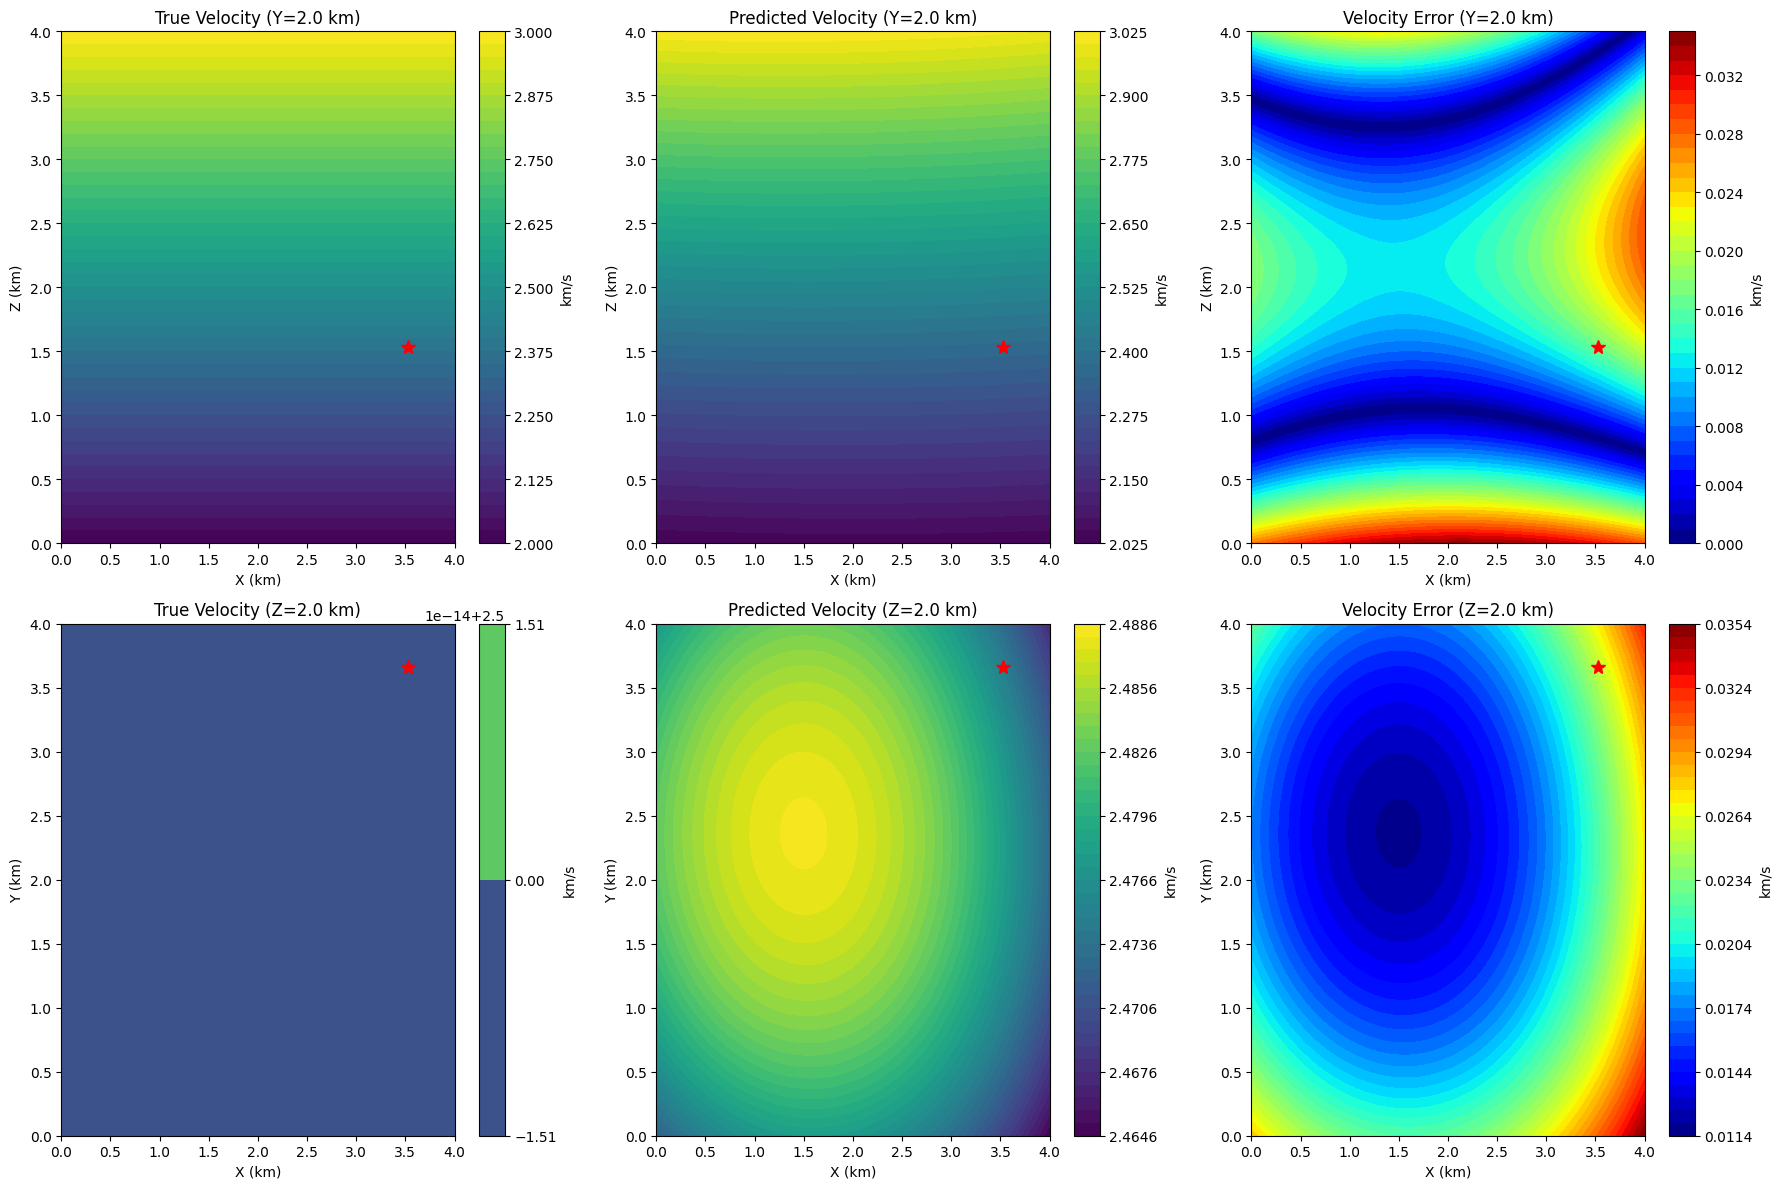

In [9]:
# ======== VISUALIZATION ========
# Convert grid to numpy arrays for plotting
X_np = X.cpu().numpy()
Y_np = Y.cpu().numpy()
Z_np = Z.cpu().numpy()
velmodel_np = velmodel.cpu().numpy()

# Select slices for visualization
y_slice_idx = ny // 2  # Middle of Y dimension
z_slice_idx = nz // 2  # Middle of Z dimension

# Velocity field plots
plt.figure(figsize=(18, 12))

# True velocity at Y-slice
plt.subplot(2, 3, 1)
plt.contourf(X_np[:, y_slice_idx, :], Z_np[:, y_slice_idx, :], 
            velmodel_np[:, y_slice_idx, :], 40, cmap='viridis')
plt.colorbar(label='km/s')
plt.xlabel('X (km)')
plt.ylabel('Z (km)')
plt.title(f'True Velocity (Y={y[y_slice_idx].item():.1f} km)')
plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)

# Predicted velocity at Y-slice
plt.subplot(2, 3, 2)
plt.contourf(X_np[:, y_slice_idx, :], Z_np[:, y_slice_idx, :], 
            v_pred[:, y_slice_idx, :], 40, cmap='viridis')
plt.colorbar(label='km/s')
plt.xlabel('X (km)')
plt.ylabel('Z (km)')
plt.title(f'Predicted Velocity (Y={y[y_slice_idx].item():.1f} km)')
plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)

# Velocity error at Y-slice
plt.subplot(2, 3, 3)
error_vel = np.abs(v_pred[:, y_slice_idx, :] - velmodel_np[:, y_slice_idx, :])
plt.contourf(X_np[:, y_slice_idx, :], Z_np[:, y_slice_idx, :], 
            error_vel, 40, cmap='jet')
plt.colorbar(label='km/s')
plt.xlabel('X (km)')
plt.ylabel('Z (km)')
plt.title(f'Velocity Error (Y={y[y_slice_idx].item():.1f} km)')
plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)

# True velocity at Z-slice
plt.subplot(2, 3, 4)
plt.contourf(X_np[:, :, z_slice_idx], Y_np[:, :, z_slice_idx], 
            velmodel_np[:, :, z_slice_idx], 40, cmap='viridis')
plt.colorbar(label='km/s')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title(f'True Velocity (Z={z[z_slice_idx].item():.1f} km)')
plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)

# Predicted velocity at Z-slice
plt.subplot(2, 3, 5)
plt.contourf(X_np[:, :, z_slice_idx], Y_np[:, :, z_slice_idx], 
            v_pred[:, :, z_slice_idx], 40, cmap='viridis')
plt.colorbar(label='km/s')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title(f'Predicted Velocity (Z={z[z_slice_idx].item():.1f} km)')
plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)

# Velocity error at Z-slice
plt.subplot(2, 3, 6)
error_vel = np.abs(v_pred[:, :, z_slice_idx] - velmodel_np[:, :, z_slice_idx])
plt.contourf(X_np[:, :, z_slice_idx], Y_np[:, :, z_slice_idx], 
            error_vel, 40, cmap='jet')
plt.colorbar(label='km/s')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title(f'Velocity Error (Z={z[z_slice_idx].item():.1f} km)')
plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)

plt.tight_layout()
plt.savefig("elm_3d_velocity_comparison.png", dpi=300)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_58104\3627054915.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


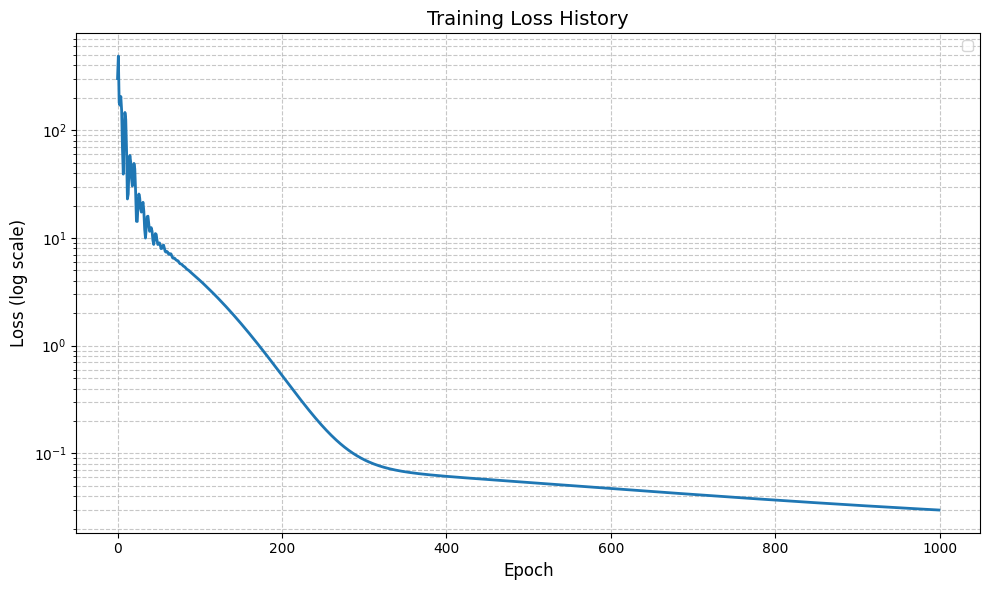


Loss Analysis:
Initial Loss: 3.0155e+02
Final Loss: 2.9785e-02
Minimum Loss: 2.9785e-02 at epoch 999
Total Reduction: 10124.2x


In [10]:
# Plot training loss history (add after training loop)
plt.figure(figsize=(10, 6))

# Use log scale for y-axis since losses decrease exponentially
plt.semilogy(loss_history, linewidth=2)
plt.title('Training Loss History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.legend(fontsize=10)
plt.tight_layout()
min_loss = min(loss_history)
min_epoch = loss_history.index(min_loss)
# Save and show
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis
print("\nLoss Analysis:")
print(f"Initial Loss: {loss_history[0]:.4e}")
print(f"Final Loss: {loss_history[-1]:.4e}")
print(f"Minimum Loss: {min_loss:.4e} at epoch {min_epoch}")
print(f"Total Reduction: {loss_history[0]/loss_history[-1]:.1f}x")


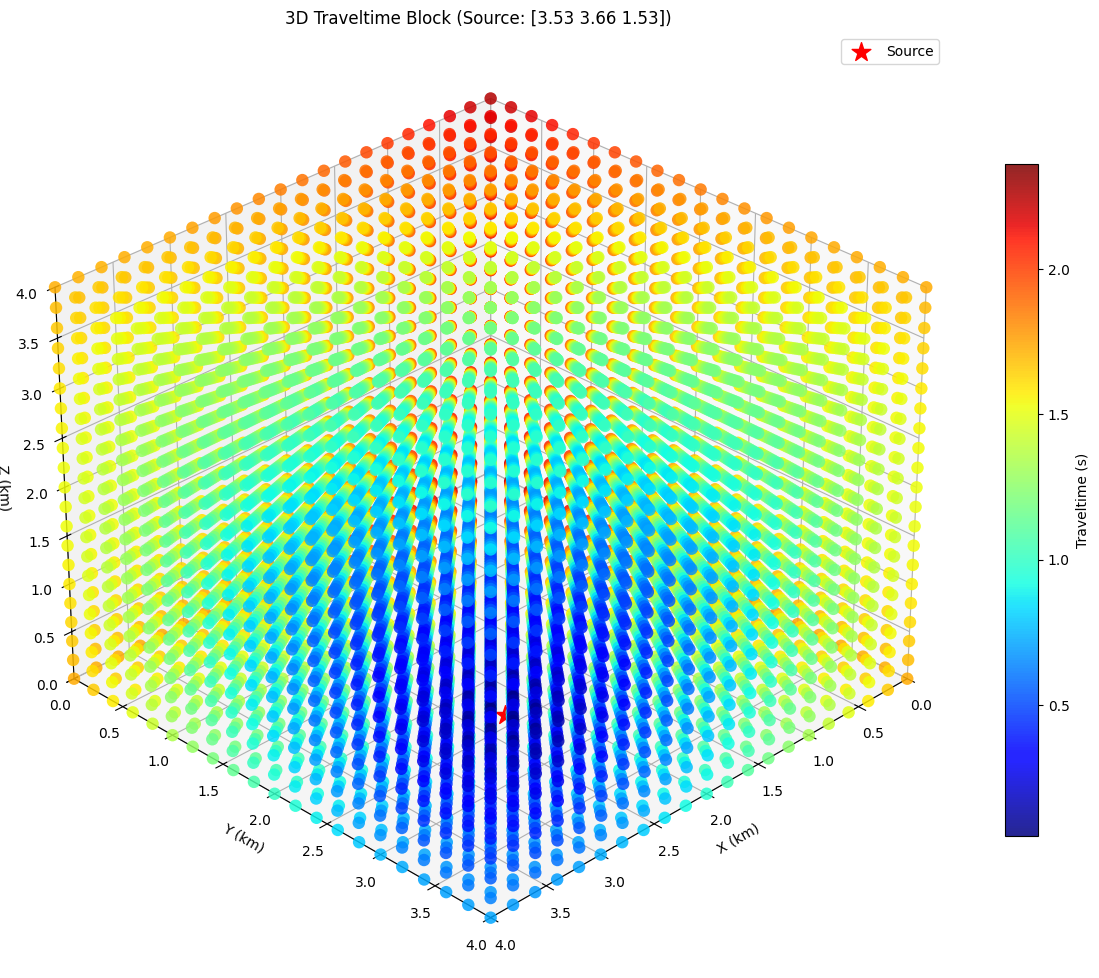

In [11]:
def plot_3d_traveltime_block_elm(elm_u, src, X, Y, Z, v0, vertgrad, step=5, cmap='jet'):
    """
    Plot 3D traveltime block using volumetric visualization with sampling for ELM models
    
    Args:
        elm_u: Trained ELM model for u (traveltime correction)
        src: Source coordinates tensor (3 elements)
        X, Y, Z: 3D grid coordinate tensors
        v0: Base velocity (km/s)
        vertgrad: Vertical velocity gradient (s^{-1})
        step: Sampling step size (reduce grid density)
        cmap: Colormap for traveltimes
    """
    # Downsample grid using step size
    x_ds = X[::step, ::step, ::step].flatten()
    y_ds = Y[::step, ::step, ::step].flatten()
    z_ds = Z[::step, ::step, ::step].flatten()
    
    coords_ds = torch.stack((x_ds, y_ds, z_ds), dim=1)
    src_rep = src.repeat(coords_ds.shape[0], 1)
    input_pts = torch.cat([coords_ds, src_rep], dim=1).to(device)
    
    # Predict traveltimes
    with torch.no_grad():
        u_pred = elm_u(input_pts)
        r = torch.norm(coords_ds - src_rep[:, :3], dim=1)
        v_ref = v0 + vertgrad * src[2]
        T0_val = r / v_ref
        T_pred = (T0_val * u_pred.squeeze()).cpu().numpy()
    
    # Convert to numpy arrays
    x_np = x_ds.cpu().numpy()
    y_np = y_ds.cpu().numpy()
    z_np = z_ds.cpu().numpy()
    
    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot with color mapping
    sc = ax.scatter(
        x_np, y_np, z_np, 
        c=T_pred, 
        cmap=cmap,
        alpha=0.85,
        s=80,  # Point size
        edgecolors='none'
    )
    
    # Plot source point
    src_np = src.cpu().numpy()
    ax.scatter([src_np[0]], [src_np[1]], [src_np[2]], 
               s=200, c='red', marker='*', label='Source')
    
    # Configure plot
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_title(f'3D Traveltime Block (Source: {src_np.round(2)})')
    
    # Add colorbar
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, aspect=20)
    cbar.set_label('Traveltime (s)')
    
    # Add legend
    ax.legend()
    
    # Set viewing angle
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.savefig("elm_3d_traveltime_block.png")
    plt.show()

# Usage example 
src0 = sources[0]  # First source
plot_3d_traveltime_block_elm(elm_u, src0, X, Y, Z, v0, vertgrad, step=5)

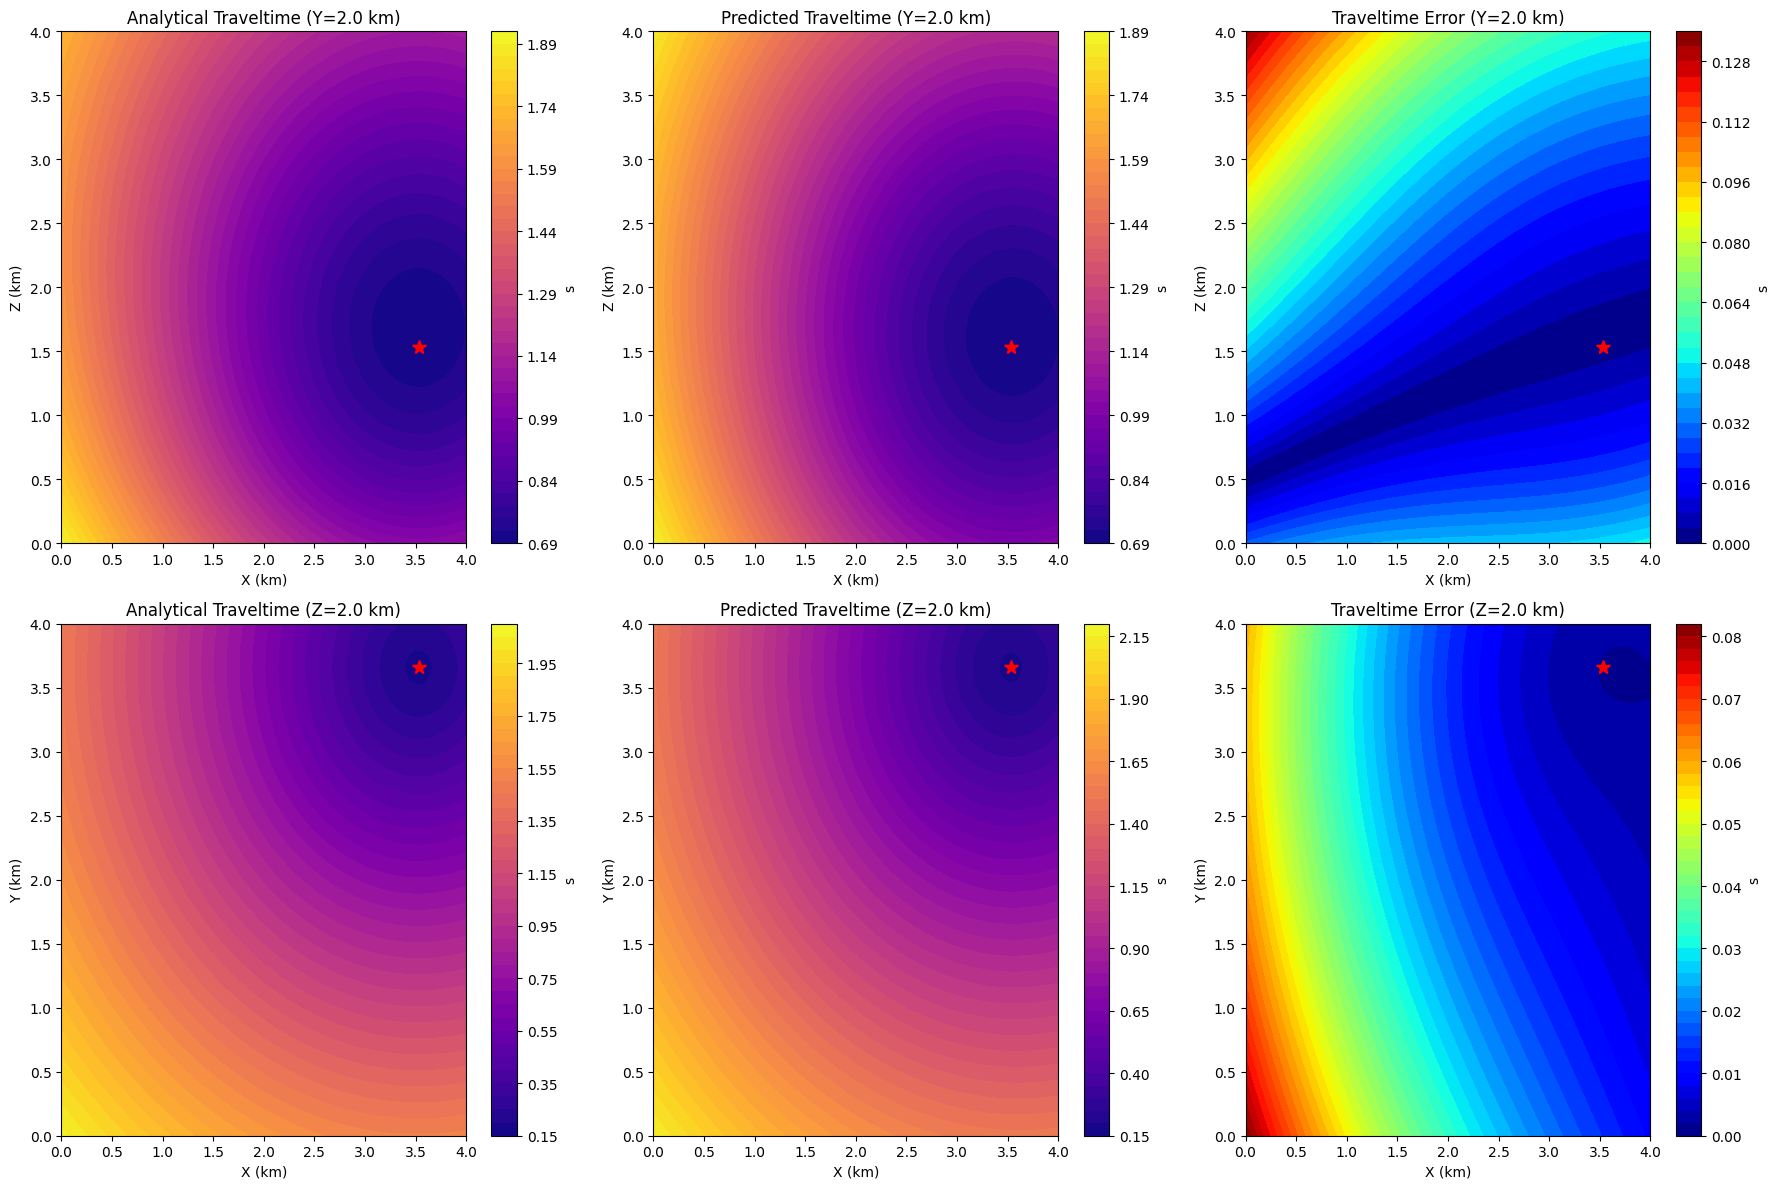

In [12]:
# Traveltime field plots
plt.figure(figsize=(18, 12))

# True traveltime at Y-slice
plt.subplot(2, 3, 1)
plt.contourf(X_np[:, y_slice_idx, :], Z_np[:, y_slice_idx, :], 
            T_anal_np[:, y_slice_idx, :], 40, cmap='plasma')
plt.colorbar(label='s')
plt.xlabel('X (km)')
plt.ylabel('Z (km)')
plt.title(f'Analytical Traveltime (Y={y[y_slice_idx]:.1f} km)')
plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)

# Predicted traveltime at Y-slice
plt.subplot(2, 3, 2)
plt.contourf(X_np[:, y_slice_idx, :], Z_np[:, y_slice_idx, :], 
            T_pred[:, y_slice_idx, :], 40, cmap='plasma')
plt.colorbar(label='s')
plt.xlabel('X (km)')
plt.ylabel('Z (km)')
plt.title(f'Predicted Traveltime (Y={y[y_slice_idx]:.1f} km)')
plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)

# Traveltime error at Y-slice
plt.subplot(2, 3, 3)
error_tt = np.abs(T_pred[:, y_slice_idx, :] - T_anal_np[:, y_slice_idx, :])
plt.contourf(X_np[:, y_slice_idx, :], Z_np[:, y_slice_idx, :], 
            error_tt, 40, cmap='jet')
plt.colorbar(label='s')
plt.xlabel('X (km)')
plt.ylabel('Z (km)')
plt.title(f'Traveltime Error (Y={y[y_slice_idx]:.1f} km)')
plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)

# True traveltime at Z-slice
plt.subplot(2, 3, 4)
plt.contourf(X_np[:, :, z_slice_idx], Y_np[:, :, z_slice_idx], 
            T_anal_np[:, :, z_slice_idx], 40, cmap='plasma')
plt.colorbar(label='s')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title(f'Analytical Traveltime (Z={z[z_slice_idx]:.1f} km)')
plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)

# Predicted traveltime at Z-slice
plt.subplot(2, 3, 5)
plt.contourf(X_np[:, :, z_slice_idx], Y_np[:, :, z_slice_idx], 
            T_pred[:, :, z_slice_idx], 40, cmap='plasma')
plt.colorbar(label='s')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title(f'Predicted Traveltime (Z={z[z_slice_idx]:.1f} km)')
plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)

# Traveltime error at Z-slice
plt.subplot(2, 3, 6)
error_tt = np.abs(T_pred[:, :, z_slice_idx] - T_anal_np[:, :, z_slice_idx])
plt.contourf(X_np[:, :, z_slice_idx], Y_np[:, :, z_slice_idx], 
            error_tt, 40, cmap='jet')
plt.colorbar(label='s')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title(f'Traveltime Error (Z={z[z_slice_idx]:.1f} km)')
plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)

plt.tight_layout()
plt.savefig("elm_3d_traveltime_comparison.png", dpi=300)
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_58104\712071679.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("elm_3d_traveltime_error_combined.png", dpi=300)
D:\pyenv\tourch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


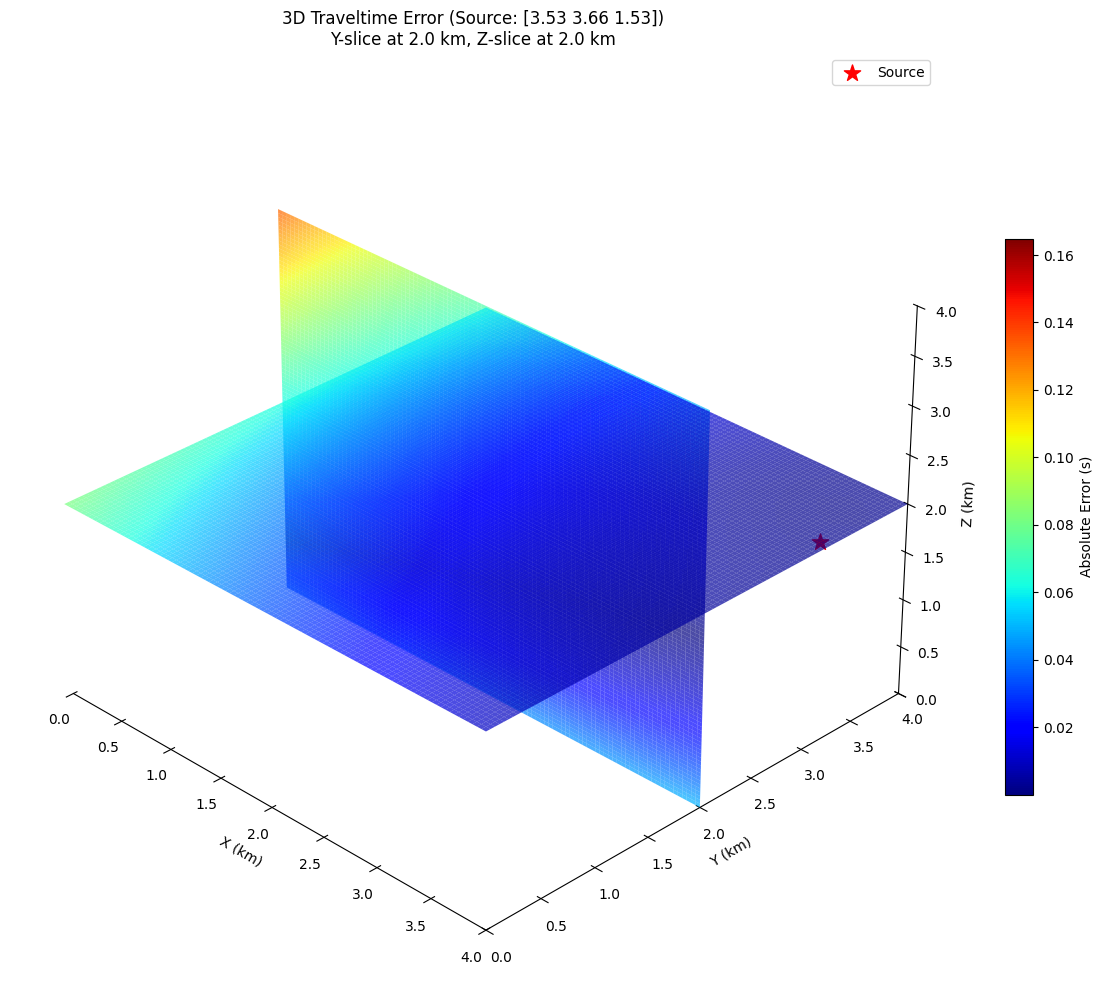

In [13]:
def plot_3d_traveltime_error(X_np, Y_np, Z_np, T_pred, T_anal_np, sources, src_idx, 
                            y_slice_idx, z_slice_idx, x_min, x_max, y_min, y_max, z_min, z_max):
    """
    Plot 3D traveltime error combining Y-slice and Z-slice views
    
    Args:
        X_np, Y_np, Z_np: 3D coordinate arrays (numpy)
        T_pred: Predicted traveltime field (3D numpy array)
        T_anal_np: Analytical traveltime field (3D numpy array)
        sources: Source coordinates
        src_idx: Index of source to visualize
        y_slice_idx: Index for Y-slice
        z_slice_idx: Index for Z-slice
        x_min, x_max: X-axis limits
        y_min, y_max: Y-axis limits
        z_min, z_max: Z-axis limits
    """
    # Select source
    src = sources[src_idx]
    
    # Calculate error
    error = np.abs(T_pred - T_anal_np)
    
    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

        # Make background transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent panes
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_facecolor('none')  # Transparent background
    
    # Prepare Y-slice data (X-Z plane at fixed Y)
    Y_slice = Y_np[0, y_slice_idx, 0]  # Y value for the slice
    X_y, Z_y = np.meshgrid(X_np[:, 0, 0], Z_np[0, 0, :], indexing='ij')
    error_y = error[:, y_slice_idx, :]
    
    # Plot Y-slice
    surf_y = ax.plot_surface(
        X_y, 
        np.full_like(X_y, Y_slice), 
        Z_y,
        facecolors=plt.cm.jet(error_y / np.max(error)),
        rstride=1, cstride=1,
        alpha=0.7, antialiased=True,
        shade=False, edgecolor='none'
    )
    
    # Prepare Z-slice data (X-Y plane at fixed Z)
    Z_slice = Z_np[0, 0, z_slice_idx]  # Z value for the slice
    X_z, Y_z = np.meshgrid(X_np[:, 0, 0], Y_np[0, :, 0], indexing='ij')
    error_z = error[:, :, z_slice_idx]
    
    # Plot Z-slice
    surf_z = ax.plot_surface(
        X_z, 
        Y_z,
        np.full_like(X_z, Z_slice),
        facecolors=plt.cm.jet(error_z / np.max(error)),
        rstride=1, cstride=1,
        alpha=0.7, antialiased=True,
        shade=False, edgecolor='none'
    )
    
    # Plot source location
    ax.scatter([src[0].item()], [src[1].item()], [src[2].item()], 
               s=150, c='red', marker='*', label='Source')
    
    # Configure plot
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_title(f'3D Traveltime Error (Source: {src.cpu().numpy().round(2)})\n'
                 f'Y-slice at {Y_slice:.1f} km, Z-slice at {Z_slice:.1f} km')
    
    # Add colorbar
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet)
    mappable.set_array(error)
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, aspect=20)
    cbar.set_label('Absolute Error (s)')
    
    # Add legend
    ax.legend()

    # Remove grid lines but keep axes
    ax.grid(False)

    # Adjust viewing angle
    ax.view_init(elev=30, azim=-45)
    
    plt.tight_layout()
    plt.savefig("elm_3d_traveltime_error_combined.png", dpi=300)
    plt.show()


# After computing T_pred and T_anal_np
src_idx = 0  # First source
y_slice_idx = ny // 2  # Middle of Y dimension
z_slice_idx = nz // 2  # Middle of Z dimension

plot_3d_traveltime_error(
    X_np, Y_np, Z_np,
    T_pred, T_anal_np,
    sources, src_idx,
    y_slice_idx, z_slice_idx,
    x_min, x_max,
    y_min, y_max,
    z_min, z_max
)

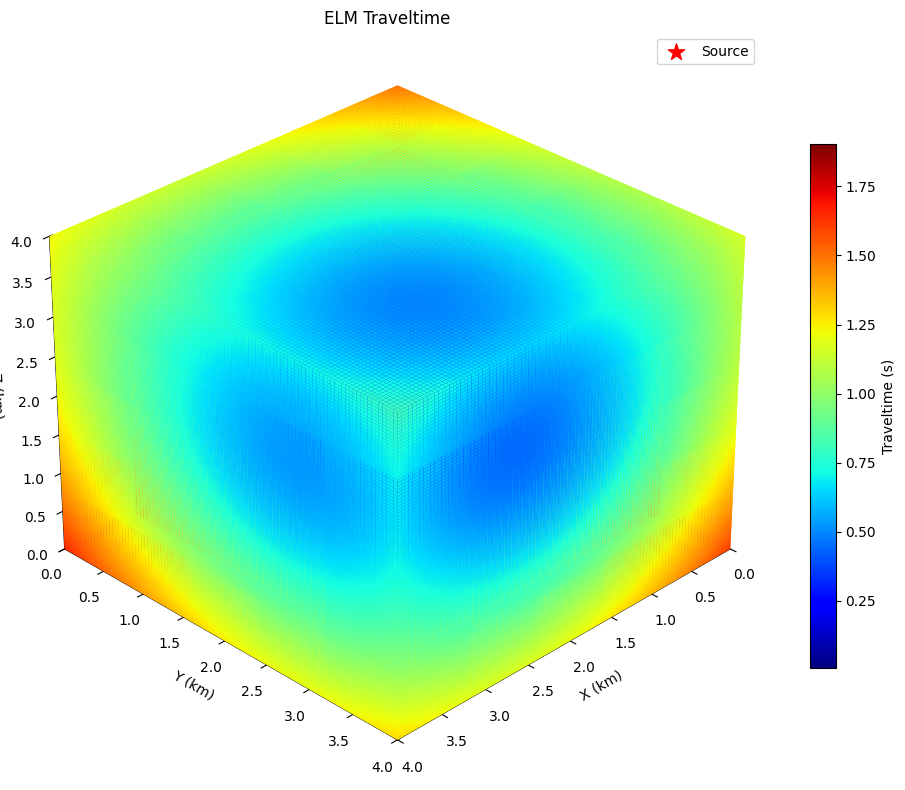

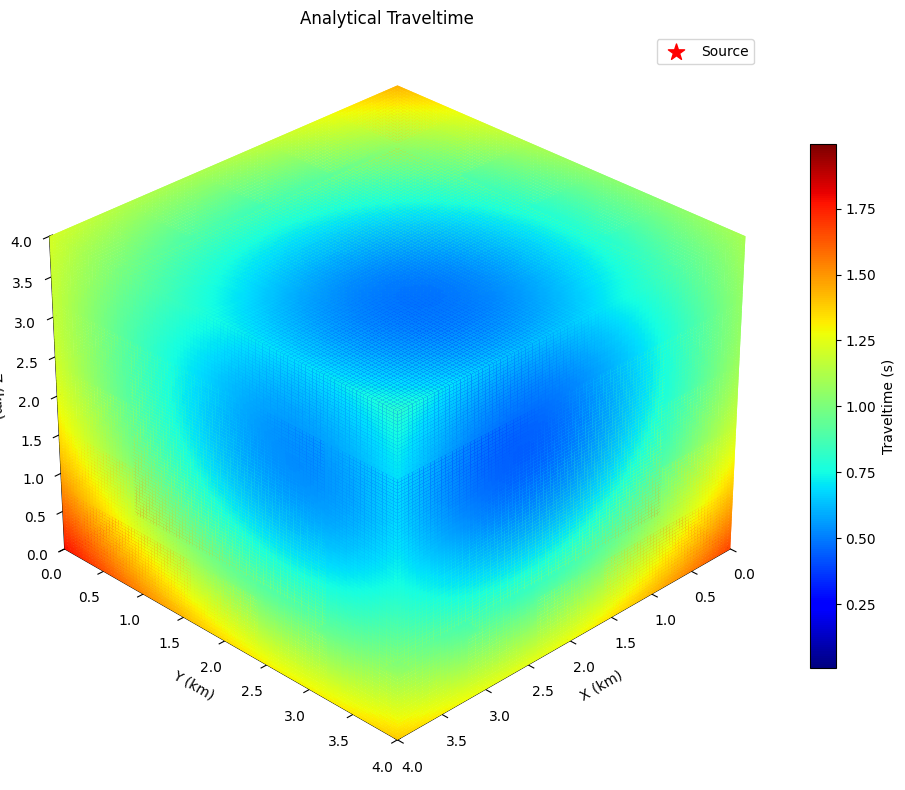

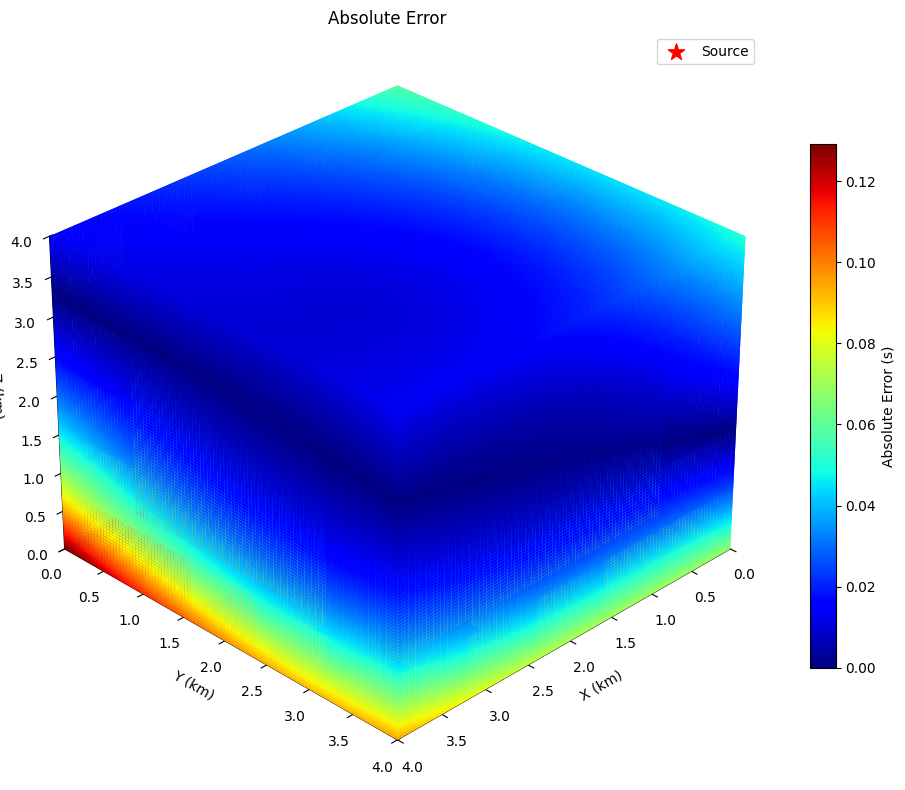

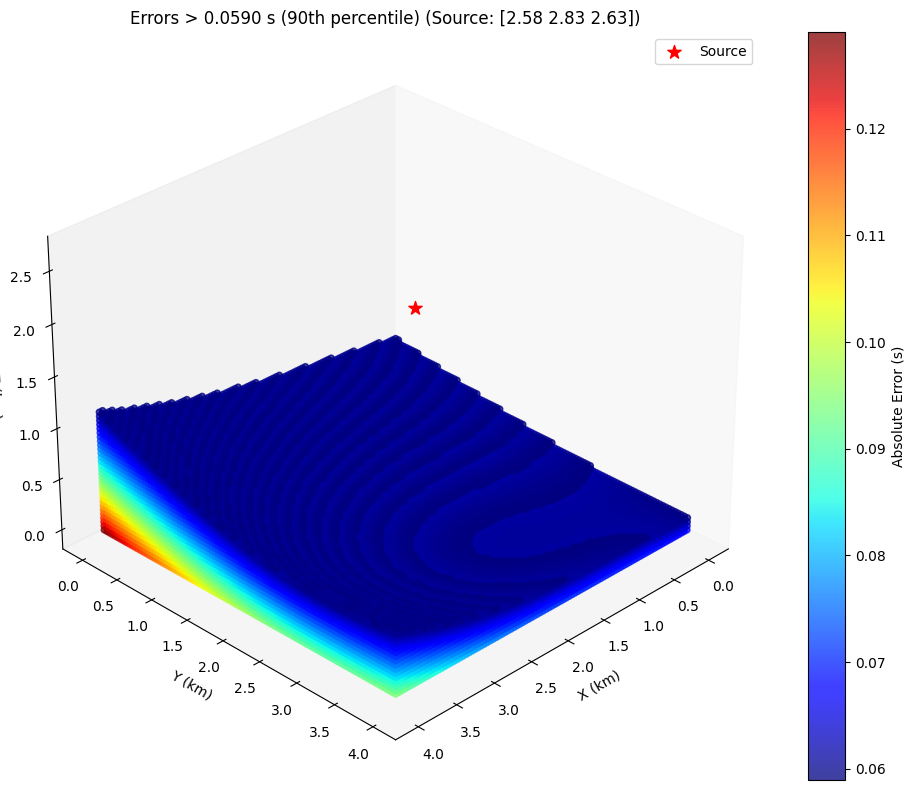


Traveltime Error Analysis:
Mean Absolute Error: 0.023425 s
Max Absolute Error: 0.129014 s
RMS Error: 0.032436 s
90th Percentile Threshold: 0.058964 s


In [19]:
def plot_3d_traveltime_comparison_elm(elm_u, src, X, Y, Z, v0, vertgrad, 
                                     num_slices=8, alpha=0.25, cmap='jet'):
    """
    Visualize ELM and analytical traveltimes as 3D volumes with slices
    and error analysis - Memory Optimized Version
    
    Args:
        elm_u: Trained ELM model for traveltime correction
        src: Source coordinates tensor (3 elements)
        X, Y, Z: 3D grid coordinate tensors
        v0: Base velocity (km/s)
        vertgrad: Vertical velocity gradient (s^{-1})
        num_slices: Number of slices in each direction
        alpha: Transparency level (0-1)
        cmap: Colormap for traveltimes
    """
    device = X.device
    nx, ny, nz = X.shape
    src_np = src.cpu().numpy()
    
    # Preallocate arrays
    T_pred = np.zeros((nx, ny, nz))
    T_anal = np.zeros((nx, ny, nz))
    
    # Compute traveltimes slice-by-slice to save memory
    for k in range(nz):
        for j in range(ny):
            # Create coordinate slice
            coords_slice = torch.stack((
                X[:, j, k].flatten(),
                Y[:, j, k].flatten(),
                Z[:, j, k].flatten()
            ), dim=1)
            
            # Create source repeated array
            src_rep = src.repeat(coords_slice.shape[0], 1)
            input_pts = torch.cat([coords_slice, src_rep], dim=1).to(device)
            
            # Predict traveltime with ELM
            with torch.no_grad():
                u_pred = elm_u(input_pts)
                r = torch.norm(coords_slice - src_rep[:, :3], dim=1)
                v_ref = v0 + vertgrad * src[2]
                T0_val = r / v_ref
                T_pred_slice = (T0_val * u_pred.squeeze()).cpu().numpy()
                T_pred[:, j, k] = T_pred_slice
            
            # Compute analytical traveltime
            x_vals = coords_slice[:, 0]
            y_vals = coords_slice[:, 1]
            z_vals = coords_slice[:, 2]
            dx = x_vals - src[0]
            dy = y_vals - src[1]
            dz = z_vals - src[2]
            r_anal = torch.sqrt(dx**2 + dy**2 + dz**2 + 1e-8)
            if vertgrad == 0:
                T_anal_slice = r_anal / v0
            else:
                v_z = v0 + vertgrad * z_vals
                arg = 1 + (vertgrad**2 * r_anal**2) / (2 * v_ref * v_z + 1e-8)
                arg = torch.clamp(arg, min=1.0+1e-8)
                T_anal_slice = (1/vertgrad) * torch.arccosh(arg)
            T_anal_slice = T_anal_slice.cpu().numpy()
            T_anal[:, j, k] = T_anal_slice
    
    # Compute error metrics
    abs_error = np.abs(T_pred - T_anal)
    max_error = np.max(abs_error)
    mean_error = np.mean(abs_error)
    rms_error = np.sqrt(np.mean(abs_error**2))
    error_threshold = np.percentile(abs_error, 90)  # 90th percentile
    
    # Get coordinate arrays
    x_np = X[:, 0, 0].cpu().numpy()
    y_np = Y[0, :, 0].cpu().numpy()
    z_np = Z[0, 0, :].cpu().numpy()
    
    # Standard figure settings
    figsize = (10, 8)
    elev = 30
    azim = 45
    
    # 1. ELM Traveltime Volume
    fig1 = plt.figure(figsize=figsize)
    ax1 = fig1.add_subplot(111, projection='3d')
    plot_3d_slices(ax1, T_pred, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, cmap, 
                   vmin=np.min(T_pred), vmax=np.max(T_pred),
                   title='ELM Traveltime')
    ax1.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.savefig("pielm_TS_traveltime_volume.png", dpi=600)
    plt.show()
    
    # 2. Analytical Traveltime Volume
    fig2 = plt.figure(figsize=figsize)
    ax2 = fig2.add_subplot(111, projection='3d')
    plot_3d_slices(ax2, T_anal, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, cmap, 
                   vmin=np.min(T_anal), vmax=np.max(T_anal),
                   title='Analytical Traveltime')
    ax2.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.savefig("pielm_TS_analytical_traveltime_volume.png", dpi=600)
    plt.show()
    
    # 3. Error Volume
    fig3 = plt.figure(figsize=figsize)
    ax3 = fig3.add_subplot(111, projection='3d')
    plot_3d_slices(ax3, abs_error, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, 'jet', 
                   vmin=0, vmax=max_error,
                   title='Absolute Error')
    ax3.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.savefig("pielm_TS_traveltime_error_volume.png", dpi=600)
    plt.show()
    
    # 4. Significant Error Points (top 10%)
    fig4 = plt.figure(figsize=figsize)
    ax4 = fig4.add_subplot(111, projection='3d')
    error_mask = abs_error > error_threshold
    coords_idx = np.where(error_mask)
    if len(coords_idx[0]) > 0:
        x_err = x_np[coords_idx[0]]
        y_err = y_np[coords_idx[1]]
        z_err = z_np[coords_idx[2]]
        errors = abs_error[error_mask]
        
        sc = ax4.scatter(
            x_err, y_err, z_err, c=errors, 
            cmap='jet', alpha=0.75, s=20
        )
        plt.colorbar(sc, ax=ax4, label='Absolute Error (s)')
    ax4.scatter([src_np[0]], [src_np[1]], [src_np[2]], 
               s=100, c='red', marker='*', label='Source')
    ax4.set_title(f'Errors > {error_threshold:.4f} s (90th percentile) (Source: {src.cpu().numpy().round(2)})')
    ax4.view_init(elev=elev, azim=azim)
    ax4.set_xlabel('X (km)')
    ax4.set_ylabel('Y (km)')
    ax4.set_zlabel('Z (km)')
    ax4.legend()
    ax4.grid(False)
    plt.tight_layout()
    plt.savefig("pielm_TS_significant_error_volume.png", dpi=600)
    plt.show()
    
    # Print error metrics
    print("\nTraveltime Error Analysis:")
    print(f"Mean Absolute Error: {mean_error:.6f} s")
    print(f"Max Absolute Error: {max_error:.6f} s")
    print(f"RMS Error: {rms_error:.6f} s")
    print(f"90th Percentile Threshold: {error_threshold:.6f} s")

def plot_3d_slices(ax, data, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, cmap, vmin, vmax, title):
    """Helper function to plot 3D slices for a volume"""
    # Configure plot appearance
    ax.grid(False)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_facecolor('none')
    
    # Create colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap_func = plt.get_cmap(cmap)
    
    # Create slices in X direction
    x_slices = np.linspace(min(x_np), max(x_np), num_slices)
    for x_val in x_slices:
        x_idx = np.abs(x_np - x_val).argmin()
        Y_surf, Z_surf = np.meshgrid(y_np, z_np, indexing='ij')
        X_surf = np.full_like(Y_surf, x_val)
        T_slice = data[x_idx, :, :]
        ax.plot_surface(X_surf, Y_surf, Z_surf, 
                        facecolors=cmap_func(norm(T_slice)),
                        rstride=1, cstride=1, alpha=alpha,
                        shade=False, edgecolor='none')
    
    # Create slices in Y direction
    y_slices = np.linspace(min(y_np), max(y_np), num_slices)
    for y_val in y_slices:
        y_idx = np.abs(y_np - y_val).argmin()
        X_surf, Z_surf = np.meshgrid(x_np, z_np, indexing='ij')
        Y_surf = np.full_like(X_surf, y_val)
        T_slice = data[:, y_idx, :]
        ax.plot_surface(X_surf, Y_surf, Z_surf, 
                        facecolors=cmap_func(norm(T_slice)),
                        rstride=1, cstride=1, alpha=alpha,
                        shade=False, edgecolor='none')
    
    # Create slices in Z direction
    z_slices = np.linspace(min(z_np), max(z_np), num_slices)
    for z_val in z_slices:
        z_idx = np.abs(z_np - z_val).argmin()
        X_surf, Y_surf = np.meshgrid(x_np, y_np, indexing='ij')
        Z_surf = np.full_like(X_surf, z_val)
        T_slice = data[:, :, z_idx]
        ax.plot_surface(X_surf, Y_surf, Z_surf, 
                        facecolors=cmap_func(norm(T_slice)),
                        rstride=1, cstride=1, alpha=alpha,
                        shade=False, edgecolor='none')
    
    # Plot source point
    ax.scatter([src_np[0]], [src_np[1]], [src_np[2]], 
               s=150, c='red', marker='*', label='Source')
    
    # Configure axes
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_xlim(min(x_np), max(x_np))
    ax.set_ylim(min(y_np), max(y_np))
    ax.set_zlim(min(z_np), max(z_np))
    
    # Add colorbar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap_func)
    mappable.set_array(data)
    cbar = plt.colorbar(mappable, ax=ax, shrink=0.7, aspect=20)
    cbar_label = 'Traveltime (s)' if 'Error' not in title else 'Absolute Error (s)'
    cbar.set_label(cbar_label)
    
    ax.set_title(title)
    ax.legend(loc='upper right')


# After training, add:
src0 = sources[18].cpu()
X_cpu = X.cpu()
Y_cpu = Y.cpu()
Z_cpu = Z.cpu()

plot_3d_traveltime_comparison_elm(
    elm_u, 
    src0, 
    X_cpu, Y_cpu, Z_cpu,
    v0, 
    vertgrad,
    num_slices=6,  # Fewer slices for faster rendering
    alpha=1      # More opaque for better visibility
)

C:\Users\user\AppData\Local\Temp\ipykernel_58104\2451134619.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("elm_3d_traveltime_error_combined.png", dpi=300)


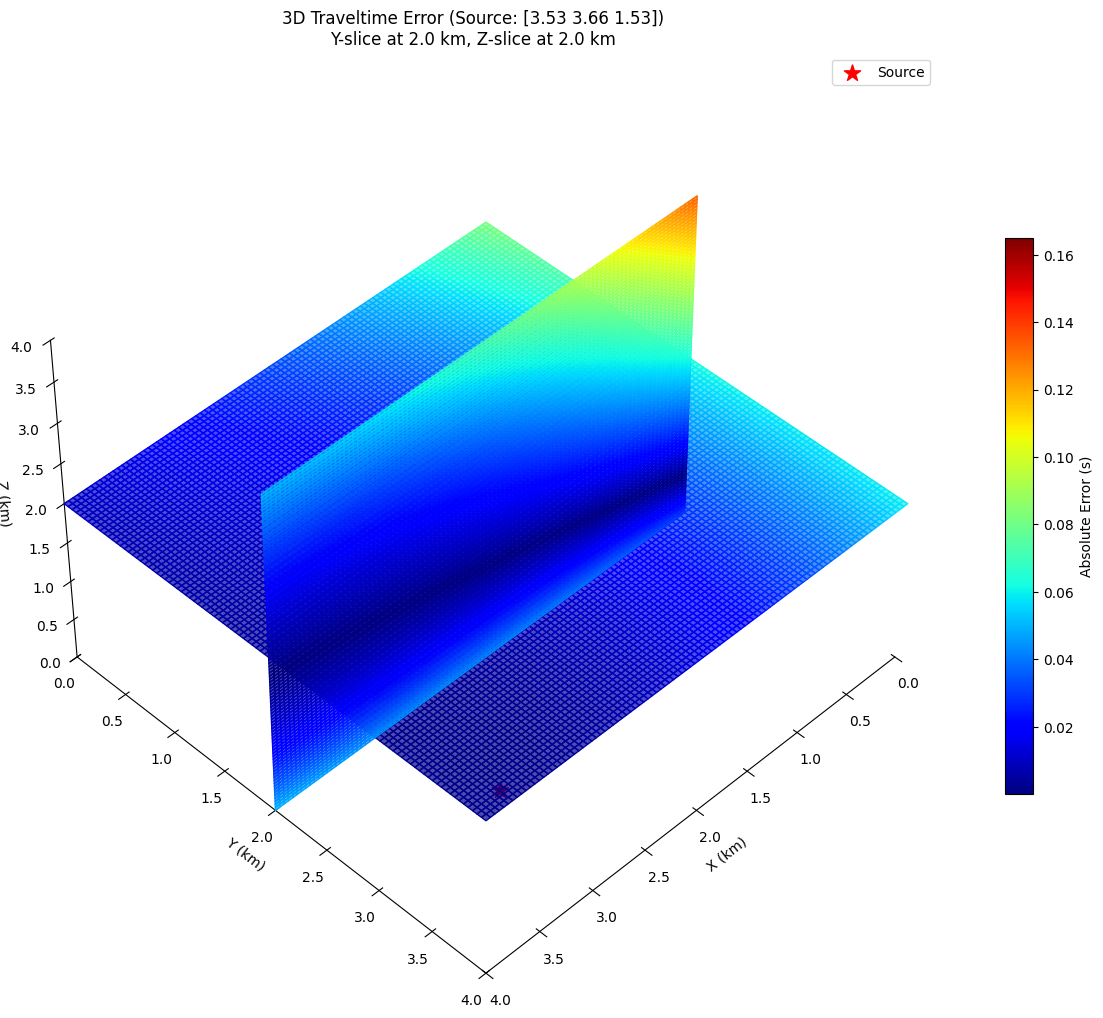

In [15]:
def plot_3d_traveltime_error(X_np, Y_np, Z_np, T_pred, T_anal_np, sources, src_idx, 
                            y_slice_idx, z_slice_idx, x_min, x_max, y_min, y_max, z_min, z_max):
    """
    Plot 3D traveltime error combining Y-slice and Z-slice views
    
    Args:
        X_np, Y_np, Z_np: 3D coordinate arrays (numpy)
        T_pred: Predicted traveltime field (3D numpy array)
        T_anal_np: Analytical traveltime field (3D numpy array)
        sources: Source coordinates
        src_idx: Index of source to visualize
        y_slice_idx: Index for Y-slice
        z_slice_idx: Index for Z-slice
        x_min, x_max: X-axis limits
        y_min, y_max: Y-axis limits
        z_min, z_max: Z-axis limits
    """
    # Select source
    src = sources[src_idx]
    
    # Calculate error
    error = np.abs(T_pred - T_anal_np)
    
    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

        # Make background transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent panes
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_facecolor('none')  # Transparent background
    
    # Prepare Y-slice data (X-Z plane at fixed Y)
    Y_slice = Y_np[0, y_slice_idx, 0]  # Y value for the slice
    X_y, Z_y = np.meshgrid(X_np[:, 0, 0], Z_np[0, 0, :], indexing='ij')
    error_y = error[:, y_slice_idx, :]
    
    # Plot Y-slice
    surf_y = ax.plot_surface(
        X_y, 
        np.full_like(X_y, Y_slice), 
        Z_y,
        facecolors=plt.cm.jet(error_y / np.max(error)),
        rstride=1, cstride=1,
        alpha=0.7, antialiased=True,
        shade=False
    )
    
    # Prepare Z-slice data (X-Y plane at fixed Z)
    Z_slice = Z_np[0, 0, z_slice_idx]  # Z value for the slice
    X_z, Y_z = np.meshgrid(X_np[:, 0, 0], Y_np[0, :, 0], indexing='ij')
    error_z = error[:, :, z_slice_idx]
    
    # Plot Z-slice
    surf_z = ax.plot_surface(
        X_z, 
        Y_z,
        np.full_like(X_z, Z_slice),
        facecolors=plt.cm.jet(error_z / np.max(error)),
        rstride=1, cstride=1,
        alpha=0.7, antialiased=True,
        shade=False
    )
    
    # Plot source location
    ax.scatter([src[0].item()], [src[1].item()], [src[2].item()], 
               s=150, c='red', marker='*', label='Source')
    
    # Configure plot
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_title(f'3D Traveltime Error (Source: {src.cpu().numpy().round(2)})\n'
                 f'Y-slice at {Y_slice:.1f} km, Z-slice at {Z_slice:.1f} km')
    
    # Add colorbar
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet)
    mappable.set_array(error)
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, aspect=20)
    cbar.set_label('Absolute Error (s)')
    
    # Add legend
    ax.legend()

    # Remove grid lines but keep axes
    ax.grid(False)

    # Adjust viewing angle
    ax.view_init(elev=45, azim=45)
    
    plt.tight_layout()
    plt.savefig("elm_3d_traveltime_error_combined.png", dpi=300)
    plt.show()


# After computing T_pred and T_anal_np
src_idx = 0  # First source
y_slice_idx = ny // 2  # Middle of Y dimension
z_slice_idx = nz // 2  # Middle of Z dimension

plot_3d_traveltime_error(
    X_np, Y_np, Z_np,
    T_pred, T_anal_np,
    sources, src_idx,
    y_slice_idx, z_slice_idx,
    x_min, x_max,
    y_min, y_max,
    z_min, z_max
)